In [1]:
# Francisco Dominguez Mateos
# 14/07/2020
# adaptation from tf2_keras... version

In [2]:
# Kernel jax_gpu
# Initial code and auxiliar functions. Don't pay attention to this
import os
import time
import random as pyrandom
import numpy as onp
import matplotlib.pyplot as plt
import cv2

import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad, lax
from jax import random
from jax.nn import relu, log_softmax
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Dense, Relu, LogSoftmax
from jax.experimental.stax import Conv, Flatten, elementwise
from jax.experimental import optimizers

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
#! pip install untangle
# The easiest way to parse xml files I have found.
import untangle

In [4]:
# dlib image object detection dataset xml file format
basepath='/media/francisco/FREEDOS/datasets/pictures/indoor_object_detection_dataset/faster_bounding_box_dataset/all'
filename='exit_fire.xml'
obj=untangle.parse(filename)
len(obj.dataset.images.image)

1086

In [40]:
def fillRec(img,x,y,w,h):
    for i in range(w-1):
        for j in range(h-1):
            img[y+j+1,x+i+1,0]=1

def fillRecSoftMax(img,x,y,w,h,label):
    img[y-1:y+h+2,x-1:x+w+2,    0]=0
    img[y-1:y+h+2,x-1:x+w+2,label]=1
    
def fillRecSoftMax_OLD(img,x,y,w,h,label):
    for i in range(w+1):
        for j in range(h+1):
            nx=x+i
            if nx>=img.shape[1]: nx=img.shape[1]-1
            if nx<0: nx=0
            ny=y+j
            if ny>=img.shape[0]: ny=img.shape[0]-1
            if ny<0: ny=0
            img[ny,nx,0]=0
            img[ny,nx,label]=1
            
def setCenter(img,top,left,width,height):
    center_x=left+width//2
    center_y=top +height//2
    y[center_y,center_x,0]=1
    
def setBlackBackground(im):
    img=im.copy()
    img[:,:,0]=0
    #for i in range(img.shape[0]):
    #    for j in range(img.shape[1]):
    #        if img[i,j,0]>0.1:
    #            img[i,j,0]=1
    return img
                
def getLabel(box):
    l=b.label.cdata
    if l=="fireextinguisher":
        return 1
    if l=="exit":
        return 2
    return 0
    
def plt_img(imi,imo):
    #plt.imshow(imi.reshape(height_i,width_i,3))
    plt.imshow(imi)
    width_i =imi.shape[1]
    height_i=imi.shape[0]
    #plt.show()
    #img_np=imo.reshape(height_o,width_o,3)
    img_np=onp.array(imo)#.reshape(height_o,width_o,3)
    img=cv2.resize(img_np,(width_i,height_i))
    #plt.imshow(img,cmap='cool',alpha=0.25)
    #plt.imshow(setBlackBackground(img),alpha=0.5)
    plt.imshow(img,alpha=0.5)


In [43]:
images=[]
labels=[]
scale=4
reduction=4
classes=3 # exit, fireextinguisher, none
for i in obj.dataset.images.image[:]:
    imgfile=os.path.join(basepath,i['file'])
    #print(imgfile)
    img=cv2.imread(imgfile)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize and 
    # normalize very important!!
    img=img/255.0
    img=cv2.resize(img, (img.shape[1]//scale, img.shape[0]//scale))
    #print(i['file'],'\t',img.shape)
    height_i=img.shape[0]
    width_i =img.shape[1]
    height_o=height_i//reduction
    width_o =width_i //reduction
    y=onp.zeros((height_o,width_o,classes))
    #fillRecSoftMax(y,0,0,width_o,height_o,0)
    y[:,:,0]=1
    for b in i.box:
        top   =int(b['top'   ])//scale//reduction
        left  =int(b['left'  ])//scale//reduction
        width =int(b['width' ])//scale//reduction
        height=int(b['height'])//scale//reduction
        label=getLabel(b)
        
        #setCenter(y,top,left,width,height)
        fillRecSoftMax(y,left,top,width,height,label)
        #print("  ",b.label.cdata,"\t->\t[",top,",",left,",",width,",",height,"]")
    images.append(img)
    labels.append(y)

In [44]:
images_np=onp.array(images)
y_train=onp.array(labels[:-100])
y_test =onp.array(labels[:100])
print(images_np.shape)
x_train=images_np[:-100]
x_test =images_np[:100]
idx=pyrandom.randint(0,y_train.shape[0])
print(x_train[idx].shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(onp.min(y_train[:,:,0]),onp.max(y_train[:,:,0]))

(1086, 180, 320, 3)
(180, 320, 3)
(986, 180, 320, 3)
(986, 45, 80, 3)
(100, 180, 320, 3)
(100, 45, 80, 3)
0.0 1.0


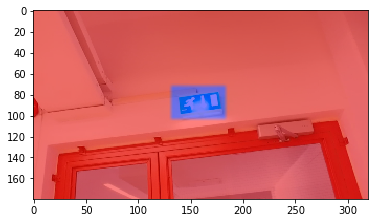

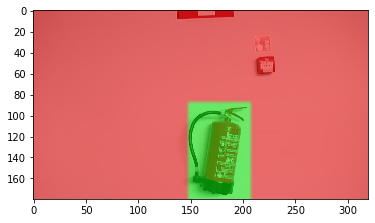

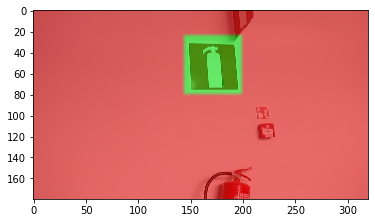

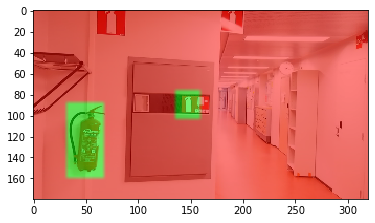

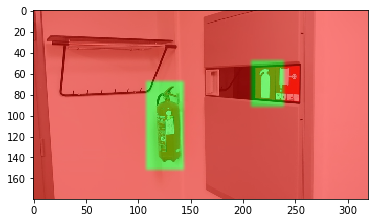

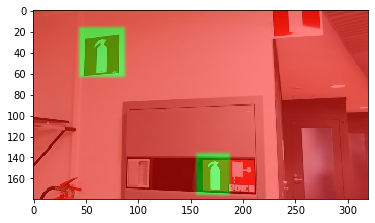

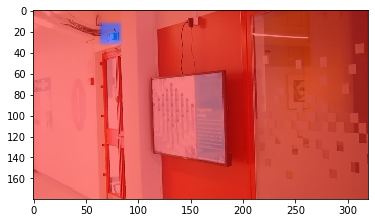

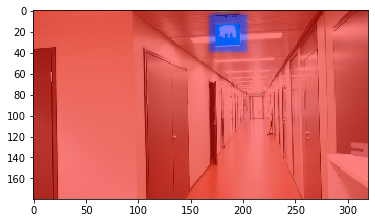

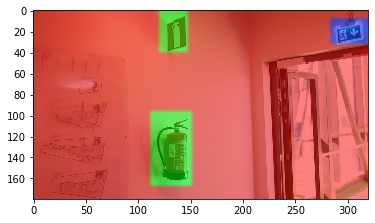

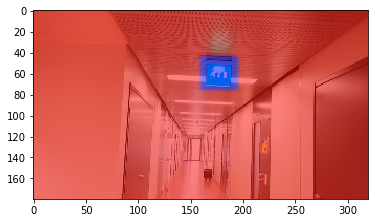

In [45]:
for i in range(10):
    idx=pyrandom.randint(0,y_train.shape[0])
    plt.figure()
    plt_img(x_train[idx],y_train[idx])
plt.show()

In [20]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

In [21]:
# The normal LogSoftmax at stax doesn't work for convolution outputs
LogSoftmax2D=elementwise(log_softmax, axis=3)

In [22]:
fcn_init, fcn = stax.serial(
    Conv(32, (5, 5), (2, 2), padding="SAME"),
    BatchNorm(), Relu,
    Conv(32, (3, 3), (2, 2), padding="SAME"),
    #BatchNorm(), Relu,
    #Conv(32, (3, 3), (2, 2), padding="SAME"),
    BatchNorm(), Relu,
    Conv(32, (7, 7), (1, 1), padding="SAME"), 
    BatchNorm(), Relu,
    Conv(32, (3, 3), (1, 1), padding="SAME"), 
    BatchNorm(), Relu,
    Conv(classes, (1, 1), (1, 1), padding="SAME"),
    LogSoftmax2D
)

In [23]:
W=int(640/2)
H=int(360/2)
input_shape=(-1,H,W,3)
output_shape, params = fcn_init(rng, input_shape)
print("output_shape=",output_shape)
fake_data=random.uniform(rng,(100,H,W,3))
print(np.max(fake_data),np.min(fake_data))
print(fake_data.shape)
pred=fcn(params,fake_data)
print("pred=",pred.shape)
print(np.max(pred),np.min(pred))

output_shape= (-1, 45, 80, 3)
0.9999999 0.0
(100, 180, 320, 3)
pred= (100, 45, 80, 3)
-0.0057089375 -6.6456223


0.9831022 0.0056581795
0.99999994 0.0


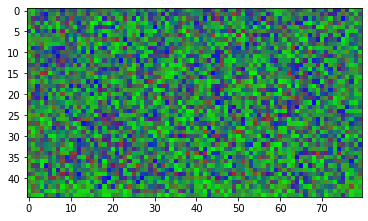

In [24]:
img=np.exp(pred[0])#np.reshape(pred[0],(28,28))
d=np.max(img)-np.min(img)
print(np.max(img),np.min(img))
img=((img-np.min(img))/d)
print(np.max(img),np.min(img))
plt.imshow(img)

In [25]:
@jit
def loss(params, images, targets):
    preds = fcn(params, images)
    #print("preds=",preds.shape)
    #print("targets=",targets.shape)
    l=-np.sum(preds * targets)
    print("loss=",l)
    return l

In [26]:
fake_targets=random.uniform(rng,(100,45,80,3))
loss(params,fake_data,fake_targets)

loss= Traced<ShapedArray(float32[]):JaxprTrace(level=-1/1)>


DeviceArray(726798.7, dtype=float32)

In [ ]:
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [28]:
@jit
def update(opt_state, x, y, ):
    """ Compute the gradient for a batch and update the parameters """
    params=get_params(opt_state)
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return opt_state
    #return get_params(opt_state), opt_state, value

In [29]:
#@jit
def run_epoch(opt_state,x_train,y_train,batch_size):
    num_complete_batches, leftover = divmod(x_train.shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    def body_fun(i, opt_state):
        #elbo_rng, data_rng = random.split(random.fold_in(rng, i))
        batch_x = lax.dynamic_slice_in_dim(x_train, i * batch_size, batch_size)
        batch_y = lax.dynamic_slice_in_dim(y_train, i * batch_size, batch_size)
        return update(opt_state, batch_x, batch_y, )
    return lax.fori_loop(0, num_batches, body_fun, opt_state)

In [30]:
eo=run_epoch(opt_state,x_train,y_train,100)

loss= Traced<ShapedArray(float32[])>with<JVPTrace(level=2/2)>
  with primal = Traced<ShapedArray(float32[]):JaxprTrace(level=0/2)>
       tangent = Traced<ShapedArray(float32[]):JaxprTrace(level=1/2)>


In [31]:
def accuracy(params, x_train,y_train):
    y_pred=np.exp(fcn(params,x_train))
    #print(y_pred.shape)
    target_class    = np.argmax(y_train, axis=3)
    #print(target_class.shape)
    predicted_class = np.argmax(y_pred , axis=3)
    #print(predicted_class.shape)
    acc_total       = np.sum(predicted_class == target_class)
    return acc_total/(x_train.shape[0]*x_train.shape[1]*x_train.shape[2])

In [56]:
def fit(opt_state, x_train,y_train,batch_size,epochs):
    for epoch in range(epochs):
        start_time=time.time()
        opt_state = run_epoch(opt_state,x_train,y_train,batch_size)
        params=get_params(opt_state)
        acc=accuracy(params,x_test,y_test)
        if epoch % 10 == 0:
            print("{: 3d} {:.6f} {:.6f} ({:.3f} sec)".format(epoch, 0, acc, time.time() - start_time))
    return opt_state

In [ ]:
num_epochs = 200
batch_size = 100
opt_state=fit(opt_state, x_train,y_train,batch_size,num_epochs)

  0 0.000000 0.061559 (3.645 sec)
 10 0.000000 0.061673 (3.588 sec)
 20 0.000000 0.061711 (3.613 sec)
 30 0.000000 0.061702 (3.616 sec)
 40 0.000000 0.061792 (3.693 sec)
 50 0.000000 0.061843 (3.601 sec)
 60 0.000000 0.061896 (3.968 sec)
 70 0.000000 0.061810 (3.763 sec)
 80 0.000000 0.061894 (3.632 sec)
 90 0.000000 0.061849 (3.605 sec)
 100 0.000000 0.061963 (3.620 sec)
 110 0.000000 0.061999 (3.640 sec)
 120 0.000000 0.061938 (3.760 sec)
 130 0.000000 0.061977 (3.733 sec)
 140 0.000000 0.061983 (3.723 sec)
 150 0.000000 0.062012 (3.738 sec)
 160 0.000000 0.061988 (4.063 sec)
 170 0.000000 0.062026 (3.796 sec)


(10, 45, 80, 3)
0.99849963 4.8852715e-05


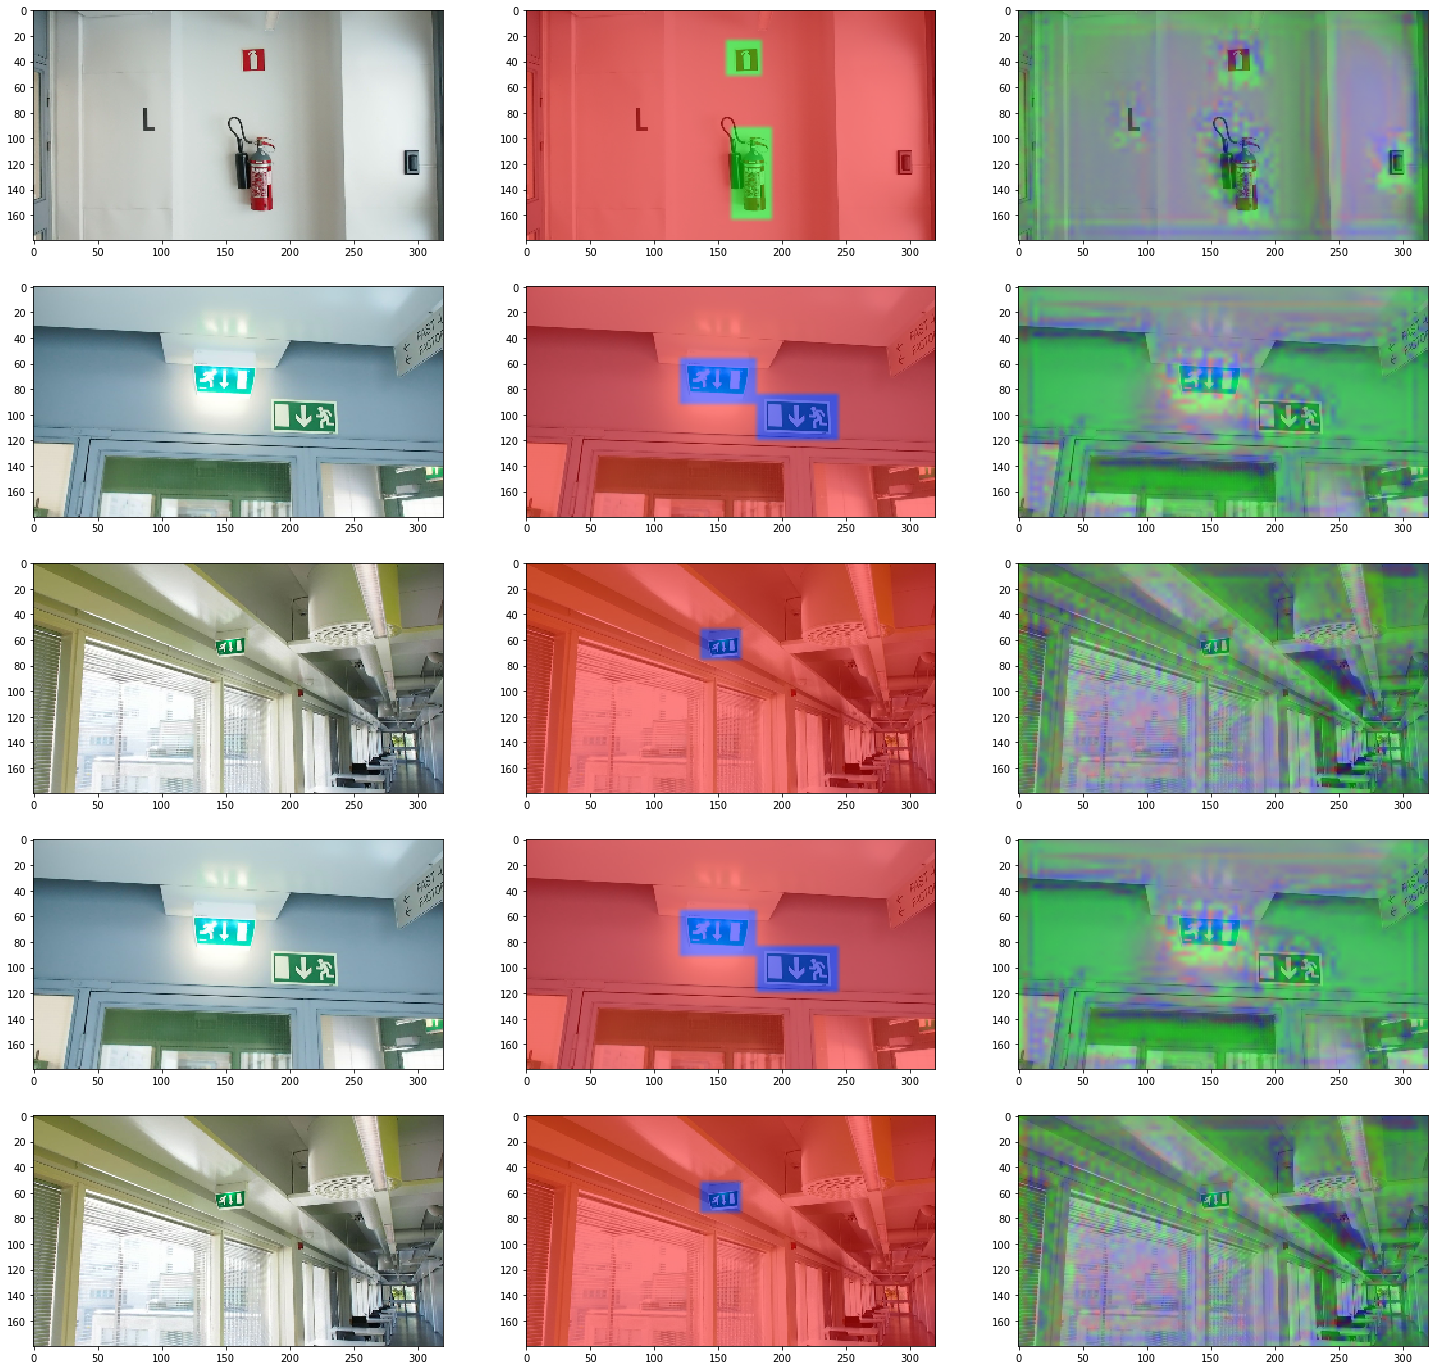

In [60]:
plt.figure(1,figsize=(25,50))
Nsamples=10
y_pred=np.exp(fcn(params,x_train[:Nsamples]))
print(y_pred.shape)
print(np.max(y_pred),np.min(y_pred))
y_dif=np.abs(y_pred-y_train[:Nsamples])
for i in range(5):
    idx=pyrandom.randint(0,Nsamples)
    #print(np.max(y_pred[idx]))
    #print(np.sum(y_dif[idx]/(height_o*width_o)))
    plt.subplot(10, 3, i*3+1)
    plt.imshow(x_train[idx].reshape(height_i,width_i,3))
    #plt.show()
    plt.subplot(10, 3, i*3+2)
    #plt.imshow(x_train[idx].reshape(height_i,width_i,3))
    #img_np=setBlackBackground(y_train[idx].reshape(height_o,width_o,3))
    #img=cv2.resize(img_np,(width_i,height_i))
    #plt.imshow(setBlackBackground(img),alpha=0.5)
    plt_img(x_train[idx],y_train[idx])
    #plt.show()
    plt.subplot(10, 3, i*3+3)
    #plt.imshow(setBlackBackground(y_pred[idx].reshape(height_o,width_o,3)))
    plt_img(x_train[idx],y_pred[idx])
    #plt.show()
    #plt.imshow(y_dif[idx].reshape(height_o,width_o),cmap="gray_r")
plt.show()

In [26]:
print("TEST")
print(x_test.shape)
y_predf=np.exp(fcn(params,x_test))
y_pred=y_predf>0.5
y_dif=np.abs(y_pred-y_test)

TEST
(100, 180, 320, 3)


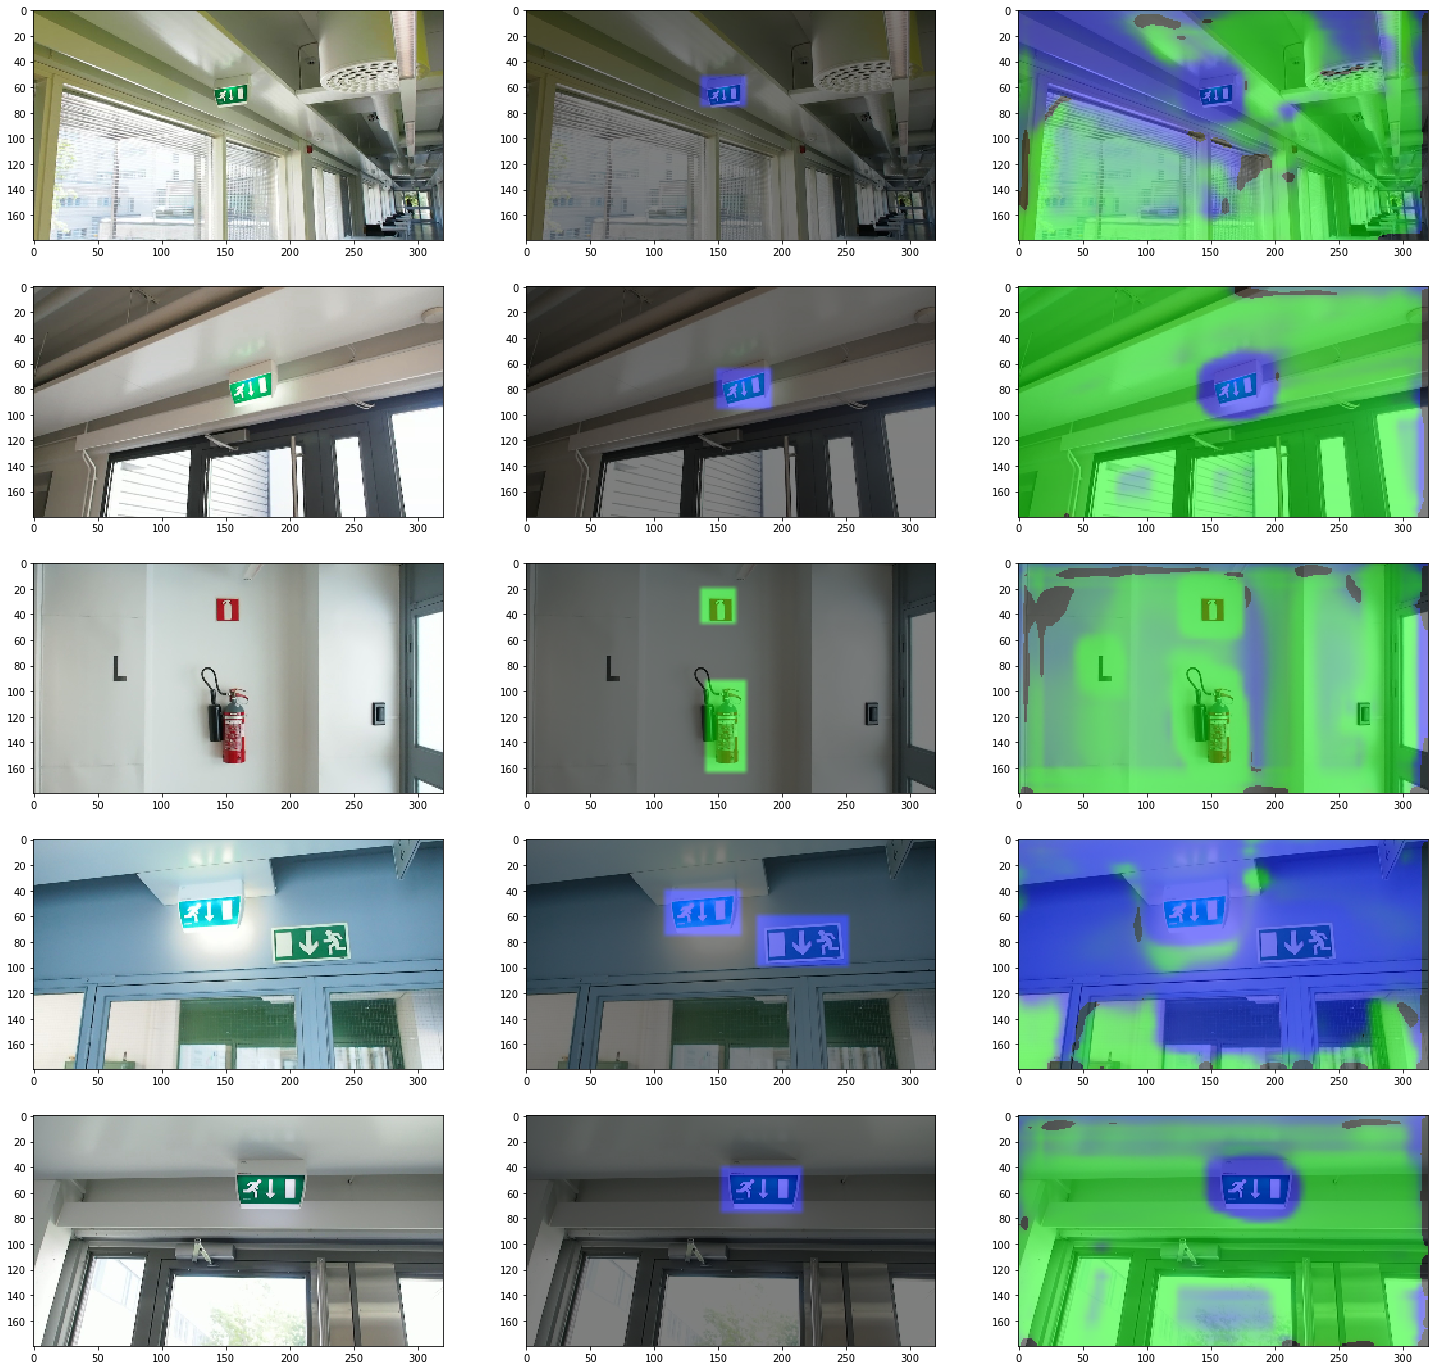

In [27]:
plt.figure(1,figsize=(25,50))
for i in range(5):
    idx=pyrandom.randint(0,x_test.shape[0])
    #print(np.max(y_predf[idx]))
    #print(np.sum(y_dif[idx]/(height_o*width_o)))
    plt.subplot(10, 3, i*3+1)
    plt.imshow(x_test[idx].reshape(height_i,width_i,3))
    #plt.show()
    plt.subplot(10, 3, i*3+2)
    plt_img(x_test[idx],y_test[idx])
    #plt.show()
    plt.subplot(10, 3, i*3+3)
    plt_img(x_test[idx],y_predf[idx])
plt.show()

In [1]:
idx=random.randint(0,x_test.shape[0])
i=obj.dataset.images.image[idx]
imgfile=os.path.join(basepath,i['file'])
img=cv2.imread(imgfile)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)/255
nf=7
plt.figure(1,figsize=(nf*2,nf*4))
for i in range(0,nf):
    #print(img.shape)
    plt.subplot(nf, 2, i*2+1)
    plt.imshow(img)
    y_predf=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
    #print(y_predf.shape)
    plt.subplot(nf, 2, i*2+2)
    plt_img(img,y_predf[0])
    img=cv2.resize(img,(int(img.shape[1]*0.7),int(img.shape[0]*0.7)))
plt.show()

NameError: name 'random' is not defined

In [144]:
y_predf=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
print(img.shape)
print(y_predf.shape)

(58, 104, 3)
(1, 7, 13, 3)


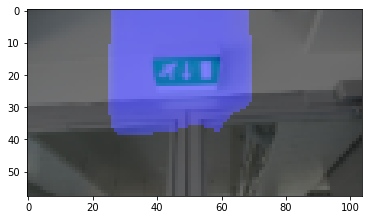

In [146]:
#plt.imshow(y_predf[0].reshape(y_predf.shape[1],y_predf.shape[2],3))
plt_img(img,y_predf[0])

plt.show()